Connexion réussie à SQL Server


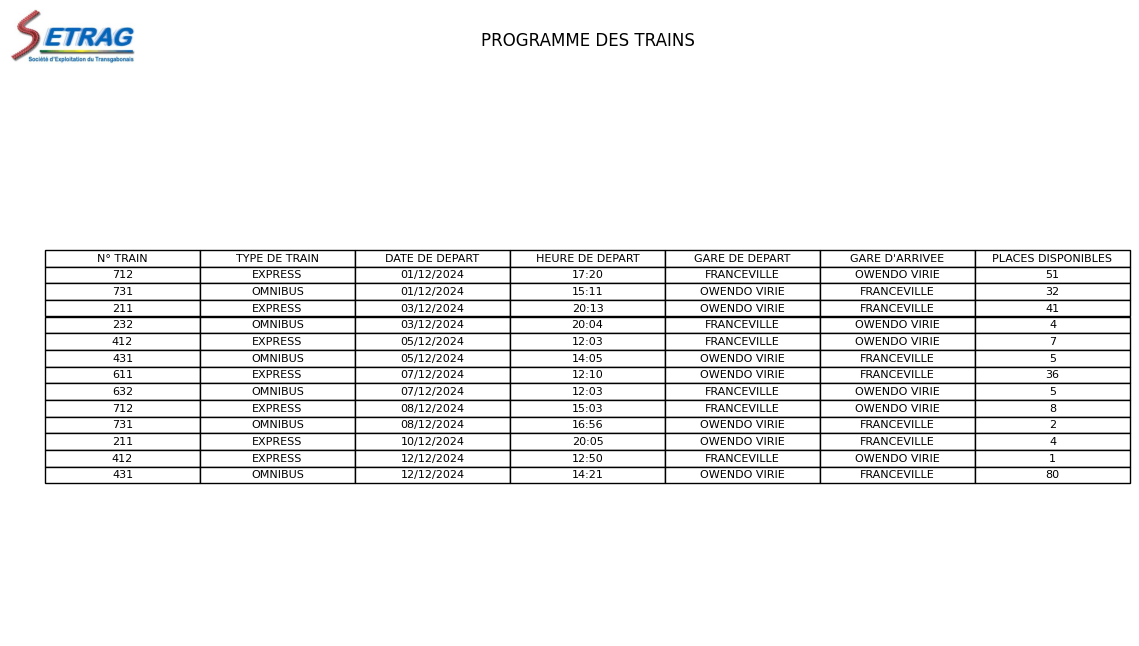

In [66]:
import pymysql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sshtunnel import SSHTunnelForwarder
import pyodbc

# Define your SSH and MySQL credentials
ssh_host = '10.120.21.103'
ssh_port = 22
ssh_user = 'setrag'
ssh_password = 'Wabjtam,123'

mysql_host = '192.168.21.69'
mysql_port = 3306
mysql_user = 'galera'
mysql_password = 'galera'
mysql_db = 'setrag_beta1'

server = 'mavagha-dv1-sqls.database.windows.net'
database = 'mavaghasqld'
username = 'SicomAdminUser'
password = 'MUdNRsrTl6eF5KjzlVcr'
driver = '{ODBC Driver 18 for SQL Server}'

# Charger l'image
image_path = 'setraglogo.jpg'
img = mpimg.imread(image_path)

try:
    conn = pyodbc.connect(
        f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password}"
    )
    print("Connexion réussie à SQL Server")
    
    cursor = conn.cursor()
    cursor.execute(
            """SELECT 
                      [NUMERO_TRAIN]
                      ,[CATEGORIE_TRAIN]
                      ,FORMAT(REAL_DT_FROM, 'dd/MM/yyyy') AS "DATE DE DEPART"
                      ,FORMAT([REAL_DT_TO], 'dd/MM/yyyy') AS "DATE D'ARRIVEE"
                	  ,FORMAT([REAL_DT_FROM], 'HH:mm') AS "HEURE DE DEPART REEL"
                	  ,FORMAT([REAL_DT_TO], 'HH:mm') AS "HEURE D'ARRIVEE REEL"
                FROM [tcs].[SP_ERAMET_VTRAIN_MINI]
                WHERE CATEGORIE_TRAIN IN ('Voyageurs express', 'Voyageurs omnibus')
                AND FORMAT(REAL_DT_TO, 'yyyy-MM-dd') BETWEEN '2024-12-01' AND '2024-12-31'
            """
        )
    results = cursor.fetchall()
    inforail_data = []
    columns = [column[0] for column in cursor.description]
    for i in results:
        donnees = (i[0], i[1], i[2], i[3], i[4], i[5])
        inforail_data.append(donnees)
    df_inforail = pd.DataFrame(inforail_data, columns=["N° TRAIN", "TYPE DE TRAIN", "DATE DE DEPART", "DATE D'ARRIVEE", "HEURE DE DEPART REEL", "HEURE D'ARRIVEE REEL"])

    cursor.close()
    conn.close()
except Exception as e:
    print(f"Erreur de connexion : {e}")

# Establish the SSH tunnel
with SSHTunnelForwarder(
    (ssh_host, ssh_port),
    ssh_username=ssh_user,
    ssh_password=ssh_password,
    remote_bind_address=(mysql_host, mysql_port)
) as tunnel:
    # Connect to the MySQL database
    connection = pymysql.connect(
        host='127.0.0.1',
        user=mysql_user,
        password=mysql_password,
        db=mysql_db,
        port=tunnel.local_bind_port
    )

    # Execute a query
    with connection.cursor() as cursor:
        #Recovery of available seats on all trains for the current month
        cursor.execute("""
                        SELECT t.number AS "N° TRAIN",
                        	   tp.label AS "TYPE DE TRAIN",
                               DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y") AS "DATE DE DEPART",
                               DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%H:%i") AS "HEURE DE DEPART",
                               IF(wdr.departure_station = 1, "OWENDO VIRIE", "FRANCEVILLE") AS "GARE DE DEPART",
                               IF(wdr.arrival_station = 23, "FRANCEVILLE", "OWENDO VIRIE") AS "GARE D'ARRIVEE",
                        	   count(sbr.seat_occupation_flag) AS "PLACES DISPONIBLES"
                        FROM train AS t
                        INNER JOIN seat_booking_record AS sbr
                        ON sbr.train_id = t.id
                        INNER JOIN seat AS s
                        ON s.id = sbr.seat_id
                        INNER JOIN car AS c
                        ON c.id = s.car_id
                        INNER JOIN train_type tp
                        ON t.train_type_id = tp.id
                        INNER JOIN week_day_route  wdr
                        ON wdr.id = t.week_day_route_id
                        WHERE
                        (t.planned_date/1000) BETWEEN UNIX_TIMESTAMP(DATE_FORMAT(CURDATE(), '%Y-%m-01 00:00:00')) AND UNIX_TIMESTAMP(DATE_FORMAT(LAST_DAY(CURDATE()), '%Y-%m-%d 23:59:59'))
                        AND sbr.seat_occupation_flag = 0 AND tp.label IN ('EXPRESS', 'OMNIBUS')
                        GROUP BY DATE_FORMAT(FROM_UNIXTIME(t.planned_date/1000), "%d/%m/%Y"), t.number
        """)
        trains_places_dispo = cursor.fetchall()
        field_names = [i[0] for i in cursor.description]
        #print(field_names)
        df = pd.DataFrame(trains_places_dispo, columns=["N° TRAIN", "TYPE DE TRAIN", "GARE DE DEPART", "DATE DE DEPART", "HEURE DE DEPART", "GARE D'ARRIVEE", "PLACES DISPONIBLES"])
        #print(df)

        df_styled = df.style.set_table_styles(
            [{'selector': 'th', 'props': [('background-color', '#FF0000'), ('color', 'white'), ('font-weight', 'bold')]}]
        )

        mob_info_matrice = []
        donnees = []
        for place in trains_places_dispo:
            for info in inforail_data:
                date_info = info[2]
                if place[0] == info[0] and place[2] == info[2]:
                    donnees = [place[0], place[1], place[2], info[4], place[4], place[5], place[6]]
                    mob_info_matrice.append(donnees)
                
                    """else:
                        donnees = (place[0], place[1], place[2], place[3], place[4], place[5], place[6])
                        mob_info_matrice.append(donnees)
                else:
                    donnees = (place[0], place[1], place[2], place[3], place[4], place[5], place[6])
                    mob_info_matrice.append(donnees)"""
        
        #print(mob_info_matrice)
        df_mob_info = pd.DataFrame(mob_info_matrice, columns=["N° TRAIN", "TYPE DE TRAIN", "DATE DE DEPART", "HEURE DE DEPART", "GARE DE DEPART", "GARE D'ARRIVEE", "PLACES DISPONIBLES"])
        #print(df_mob_info)

        # Plot the DataFrame as a table
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.axis('tight')
        ax.axis('off')

        ax.set_title("PROGRAMME DES TRAINS", y=1.08)

        table = ax.table(cellText=df_mob_info.values, colLabels=df_mob_info.columns, cellLoc='center', loc='center')

        # Ajouter un nouvel axe pour le logo
        logo_ax = fig.add_axes([0.1, 0.92, 0.09, 0.085], anchor='NE', zorder=-1)
        logo_ax.imshow(img)
        logo_ax.axis('off')  # Masquer les axes du logo
        
        # Save the table as a JPEG image
        plt.savefig('mobipass_inforail.jpg', format='jpeg')

    # Close the connection
    connection.close()